Notebook containing Analysis for positron anihillation experiment

In [13]:
import compton.Dataloader as dl
from compton.Functions import *
from compton.Analysis import *
from positron.Dataloader import *
from positron.Analysis import *
import os
from sympy import symbols, Eq, latex
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.interpolate import interp1d
from scipy.stats import poisson
import pandas as pd


First step is to make a fit for energies to rescale the energy readings from the osprey. We will do this by fitting the known values of each peak vs the experimental values, to obtain a function that brings us from known value up to actual value. 

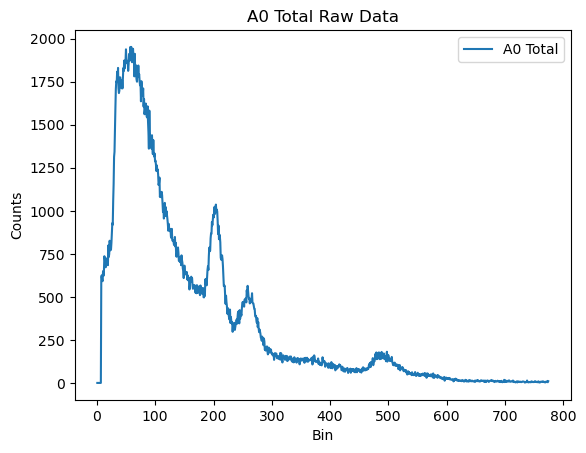

In [14]:
base_path = "../Databases/Positron/"

A0Total = load_gamma_count(base_path + "A0Total.csv")# 60 minute run?
plot_raw(A0Total, "0 Total")

Angle not int, defaulting to 0


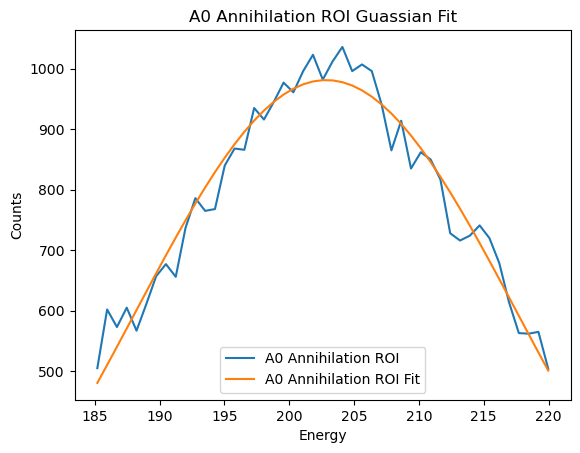

Angle not int, defaulting to 0


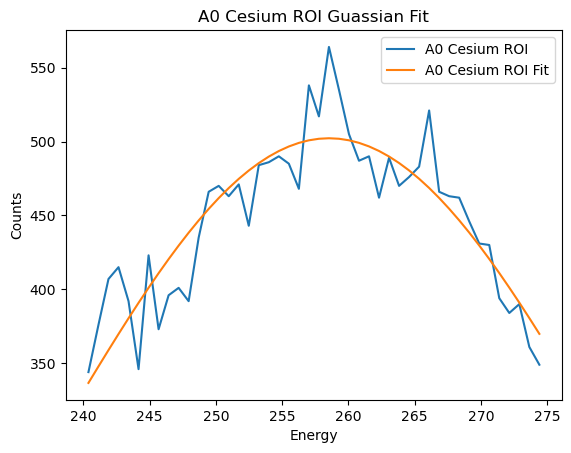

Angle not int, defaulting to 0


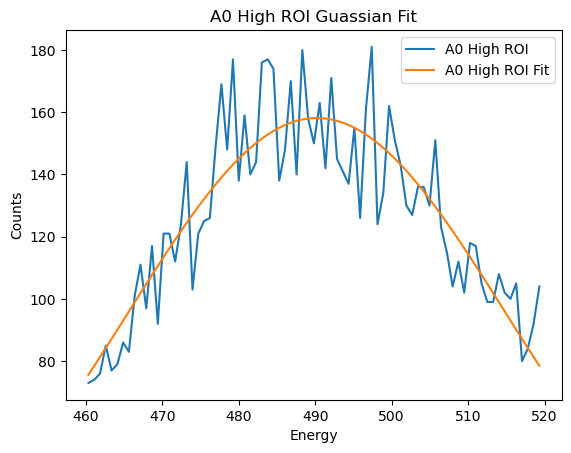

,Mean,Sigma,Unc Mean,Unc Sigma
ROI,,,,
Annihilation,202.847230,-14.770342,0.166890,0.265753
Cesium,258.528883,20.291174,0.390411,0.852153
High,490.217417,24.585945,0.519993,0.820401


In [15]:
#define 3 ROIs, that we will fit guassians to


annihilation_roi = trim_df(A0Total, 185, 220)
plot_guassian_fit(annihilation_roi, angle = "0 Annihilation ROI", p0_overide=[1000, 200, 20])

cesium_roi = trim_df(A0Total, 240, 275)
plot_guassian_fit(cesium_roi, angle = "0 Cesium ROI", p0_overide=[500, 260, 20])

high_roi = trim_df(A0Total, 460, 520)
plot_guassian_fit(high_roi, angle = "0 High ROI", p0_overide=[175,490,20,])

ROIs = {"Annihilation": annihilation_roi, "Cesium": cesium_roi, "High": high_roi}
peaks = run_all_peak_fits(ROIs)
display(peaks)

2.651122254982154 -25.263595647953547
0.011282522286909123 3.844329555333993


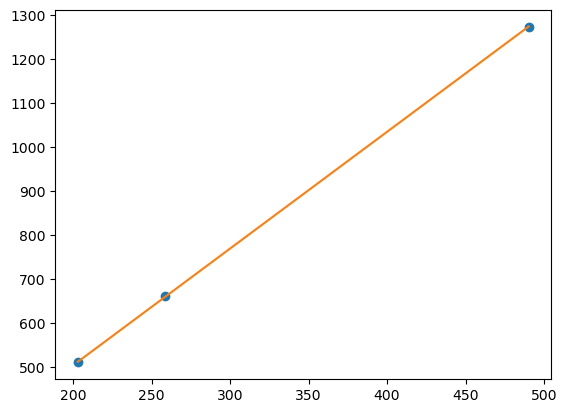

In [16]:
slope, intercept, sig_slope, sig_int = fit_plot_calibration(peaks, [511, 662, 1274])
print(slope, intercept)
print(sig_slope, sig_int)

In [17]:
dfs = load_positron_angles("../Databases/Positron/") #dfs is a dictionary, not a list
print(dfs.keys())
print(dfs[0].head())
dfs = {angle: trim_df(df, 0, 300) for angle, df in dfs.items()}



dict_keys([-6, -5, -4, -3, -2, -1, 0, 1, 2, 3, 4, 5, 6])
   Channel  Energy (keV)  Counts
0        1      0.755920       0
1        2      1.511840       0
2        3      2.267760       0
3        4      3.023679       0
4        5      3.779599       0


In [18]:
#for angle, df in dfs.items():
    #plot_raw(df, angle)

,Counts,Error,normalized_counts,normalized_error
Angle,,,,
-6,4,2.000000,0.000880,0.000440
-5,8,2.828427,0.001760,0.000622
-4,71,8.426150,0.015622,0.001854
-3,356,18.867962,0.078328,0.004151
-2,663,25.748786,0.145875,0.005665
-1,731,27.037012,0.160836,0.005949
0,839,28.965497,0.184598,0.006373
1,821,28.653098,0.180638,0.006304
2,558,23.622024,0.122772,0.005197


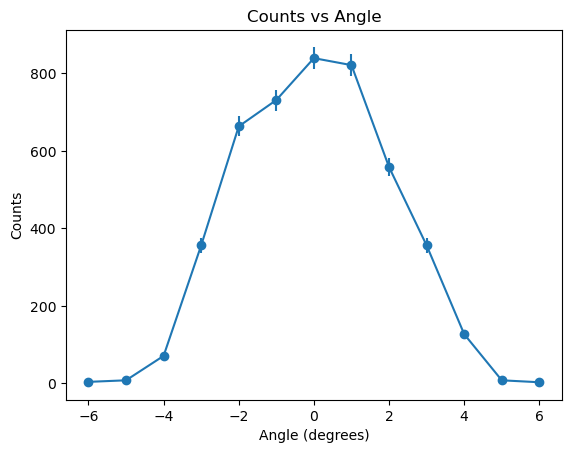

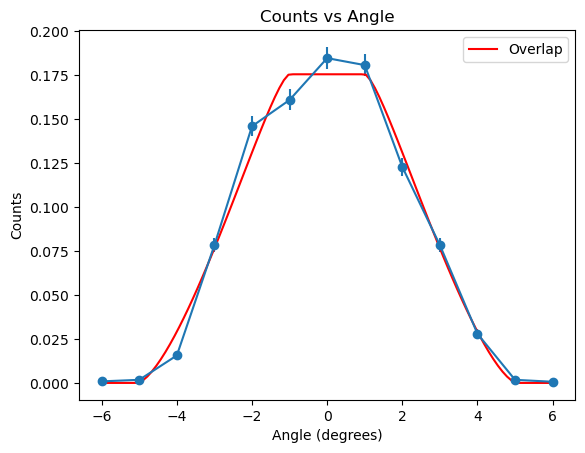

In [19]:
counts = total_counts(dfs)
display(counts)
plot_counts(counts)
plot_counts(counts, Normalized=True, overlap=True) #need to normalize by area

Part 2: time window analysis

The next step is to identify counts for specific ROIs on the 15 degree angle accidental coincidence rate

first step: obtain dataframes with counts for the 15 degree angle by ROI. should be 2 rows, one for each ROI. 
columns should be the counts per second for osprey 1, counts per second for osprey 2, and accidental coincidence counts per second

big problem: where is 1274 kev peak?!!!

I think we have to rescale the energies. not clear exactly how to do this.

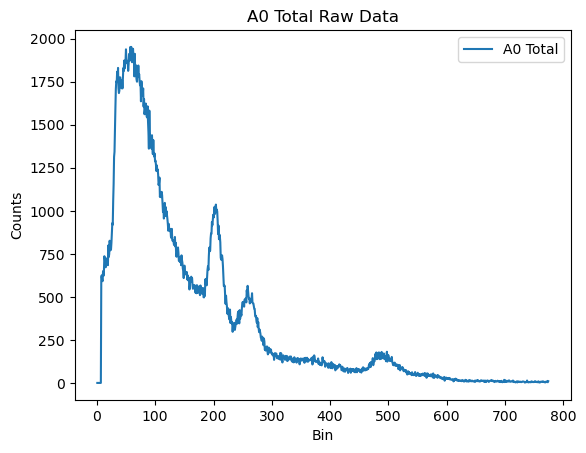

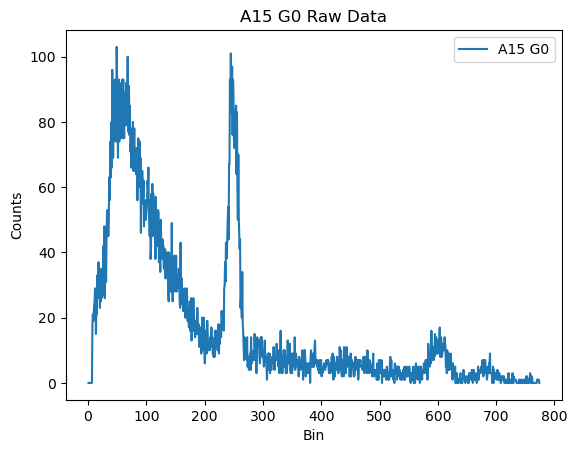

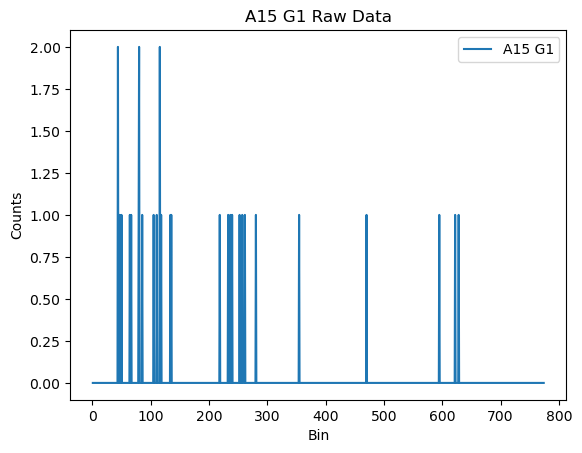

In [20]:
base_path = "../Databases/Positron/"

A0Total = load_gamma_count(base_path + "A0Total.csv", )# 60 minute run?
plot_raw(A0Total, "0 Total")
A15G0 = load_gamma_count(base_path + "A15G0.csv",) #g2 means coinicidence turned off "ungated". note: 20 minute run!
plot_raw(A15G0, "15 G0")
A15G1 = load_gamma_count(base_path + "A15G1.csv",) #G1 means coincidence turned on. "gated" note: 20 minute run!!
plot_raw(A15G1, "15 G1")

2.6207914033987976 -11.921896871018312
0.05578603648085122 18.963475926465144


,Mean,Sigma,Unc Mean,Unc Sigma
ROI,,,,
Annihilation,248.564197,9.887556,0.279052,0.279645
High,601.492326,17.418740,1.027782,1.390864


2.1619132543986996 -26.37423212719875
inf inf


/home/lucas/repos/advanced_exp/positron/Analysis.py:118: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(linear, x, y,)


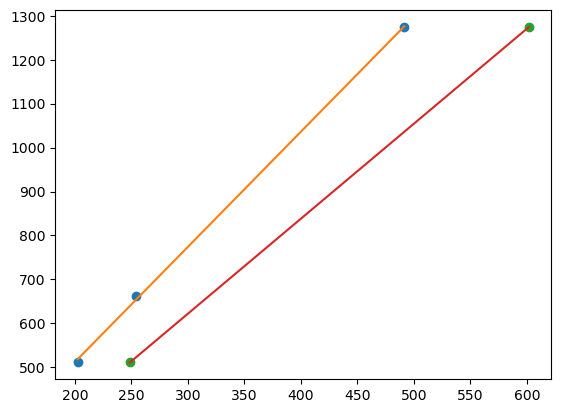

In [21]:
A0Total = recalibrate_energy(A0Total, [180, 220, 450], [220, 280, 550])
A15G0 = recalibrate_energy(A15G0, [220, 575], [280, 625])

In [22]:
slope, interept = 2.1619132196793442,  -26.37421124377178
A15G1["Energy (keV)"] = linear(A15G1["Energy (keV)"], slope, intercept)

In [23]:
"""
plot(A0Total, "0 rescaled")
plot(A15G0, "15 G0 rescaled")
plot(A15G1, "15 G1 rescaled")
"""

'\nplot(A0Total, "0 rescaled")\nplot(A15G0, "15 G0 rescaled")\nplot(A15G1, "15 G1 rescaled")\n'

In [24]:
observations = {"n1": A0Total, "n2": A15G0, "N_acc": A15G1}
index = ["full range"]
unnormalized_rates = pd.DataFrame(index=index)

"""
for key, df in observations.items():
    roi511 = trim_df(df, 511-35, 511+35)
    plot(roi511, key)
    counts511 = roi511["Counts"].sum()
    
    roi1274 = trim_df(df, 1274-75, 1274+75)
    plot(roi1274, key)
    counts1274 = roi1274["Counts"].sum()
    unnormalized_rates[key] = [counts511, counts1274]
    unnormalized_rates[key+"_error"] = [np.sqrt(counts511), np.sqrt(counts1274)]
"""
for key, df in observations.items():
    if key == "_N_acc":
        roi = trim_df(df, 511-35, 511+35)
        plot(roi, key)
        counts = roi["Counts"].sum()
    else:
        counts = df["Counts"].sum()
    unnormalized_rates[key] = [counts]
    unnormalized_rates[key+"_error"] = [np.sqrt(counts)]
    
display(unnormalized_rates)
gate_length = 2.0e-07 #200 ns gate length
print(gate_length)
rates = time_normalize(unnormalized_rates.copy(), gate_length)


rates["Tau (seconds)"] = (rates["N_acc"] / (rates["n1"] * rates["n2"]))
rates["Tau uncertainty"] = window_error(rates["n1"], rates["n2"], rates["n1_error"], rates["n2_error"], rates["N_acc"], rates["N_acc_error"])
rates["N_predicted"] = rates["n1"] * rates["n2"] * gate_length * 1200 #calculate the predicted N using known tau value
display(rates)


,n1,n1_error,n2,n2_error,N_acc,N_acc_error
full range,384820,620.338617,18068,134.417261,30,5.477226


2e-07
0.013668273884049476


,n1,n1_error,n2,n2_error,N_acc,N_acc_error,Tau (seconds),Tau uncertainty,N_predicted
full range,56.951141,0.091807,60.226667,0.448058,0.025,0.004564,0.000007,0.000001,0.823195


In [38]:
pred_20min = rates["N_predicted"].iloc[0]*1200 #use .iloc to get actual value, not the series
n_acc = rates["N_acc"].iloc[0]*1200
print("predicted N for 20 min run: ", pred_20min)
print("actual N for 20 min run: ", n_acc)
tail = poisson.cdf(n_acc, pred_20min)
print("tail: ", tail)
interval = poisson.interval(0.95, n_acc)
print("confidence interval: ", int(interval[0]), "," , int(interval[1]))
tau = rates["Tau (seconds)"].iloc[0]
tau_uncertainty = rates["Tau uncertainty"].iloc[0]
print("observed tau:", tau, "±", tau_uncertainty)


predicted N for 20 min run:  987.8334901480237
actual N for 20 min run:  30.0
tail:  0.0
confidence interval:  20 , 41
observed tau: 7.2886777698953125e-06 ± 1.331880541543644e-06


the observations and predictions are so far away from each other that the chance of their being compatible is too small to represent with a floating point. The problem is that Tau is not indeed 200 ns but rather closer to 7 microseconds. 